In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pickle
from joblib import dump


In [3]:
# 1. Pengumpulan Data
data = pd.read_csv('Gabung_Cleaned_2.csv')


In [4]:
# 2. Priproses Data
# Ganti nilai '-' dengan NaN dan kemudian drop NaN
data.replace('-', np.nan, inplace=True)
data.dropna(subset=['RSRP', 'Longitude', 'Latitude'], inplace=True)

In [5]:
# Normalisasi data numerik
scaler = StandardScaler()
data[['RSRP', 'Longitude', 'Latitude']] = scaler.fit_transform(data[['RSRP', 'Longitude', 'Latitude']])


In [6]:
# 3. Clustering Data
# Pilih fitur yang relevan untuk clustering
features = data[['RSRP', 'Longitude', 'Latitude']]


In [7]:
# Menentukan jumlah kluster optimal menggunakan Elbow Method
range_n_clusters = range(1, 11)
inertia = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

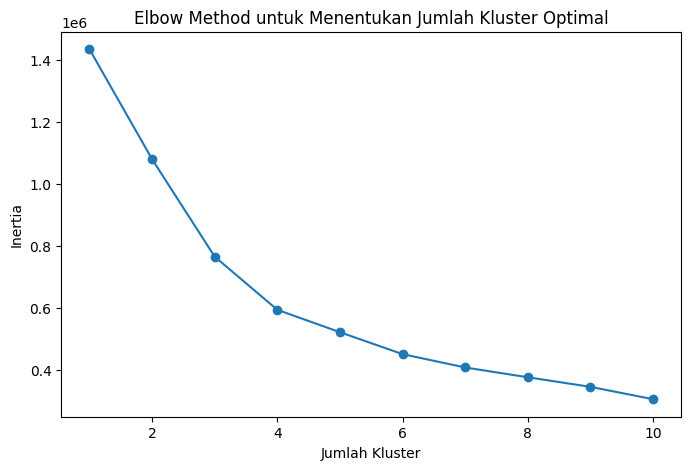

In [8]:
# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method untuk Menentukan Jumlah Kluster Optimal')
plt.xlabel('Jumlah Kluster')
plt.ylabel('Inertia')
plt.show()

In [9]:
# Tentukan jumlah kluster
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features)

KMeans(n_clusters=4, random_state=42)

In [10]:
# Tambahkan kolom 'cluster' ke data
data['cluster'] = kmeans.predict(data[['RSRP', 'Longitude', 'Latitude']])


In [11]:
# 4. Prediksi RSRQ
# Split data untuk training dan testing
X = data[['RSRP', 'Longitude', 'Latitude', 'cluster']]
y = data['RSRQ']
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Inisialisasi model Random Forest
rf = RandomForestRegressor(random_state=42)


In [13]:
# Latih model Random Forest
rf.fit(train_data, train_labels)


RandomForestRegressor(random_state=42)

In [26]:
# Simpan model KMeans dan Random Forest ke dalam file .pkl
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

# Simpan scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [14]:
# Evaluasi model
# Prediksi pada data test
test_predictions = rf.predict(test_data)


In [15]:
# Hitung Mean Squared Error (MSE)
mse = mean_squared_error(test_labels, test_predictions)
print(f'Mean Squared Error (MSE) prediksi RSRQ: {mse:.2f}')

# Hitung R-squared (R²)
r2 = r2_score(test_labels, test_predictions)
print(f'R-squared (R²) prediksi RSRQ: {r2:.2f}')

# Hitung Mean Absolute Error (MAE)
mae = mean_absolute_error(test_labels, test_predictions)
print(f'Mean Absolute Error (MAE) prediksi RSRQ: {mae:.2f}')

# Hitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) prediksi RSRQ: {rmse:.2f}')

Mean Squared Error (MSE) prediksi RSRQ: 6.29
R-squared (R²) prediksi RSRQ: 0.51
Mean Absolute Error (MAE) prediksi RSRQ: 1.79
Root Mean Squared Error (RMSE) prediksi RSRQ: 2.51


In [ ]:
from sklearn.model_selection import GridSearchCV

# Definisikan parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inisialisasi model Random Forest
rf = RandomForestRegressor(random_state=42)

# Inisialisasi Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Latih Grid Search
grid_search.fit(train_data, train_labels)

# Model terbaik
best_rf = grid_search.best_estimator_

# Evaluasi model terbaik
test_predictions = best_rf.predict(test_data)
mse = mean_squared_error(test_labels, test_predictions)
r2 = r2_score(test_labels, test_predictions)
mae = mean_absolute_error(test_labels, test_predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE) prediksi RSRQ: {mse:.2f}')
print(f'R-squared (R²) prediksi RSRQ: {r2:.2f}')
print(f'Mean Absolute Error (MAE) prediksi RSRQ: {mae:.2f}')
print(f'Root Mean Squared Error (RMSE) prediksi RSRQ: {rmse:.2f}')

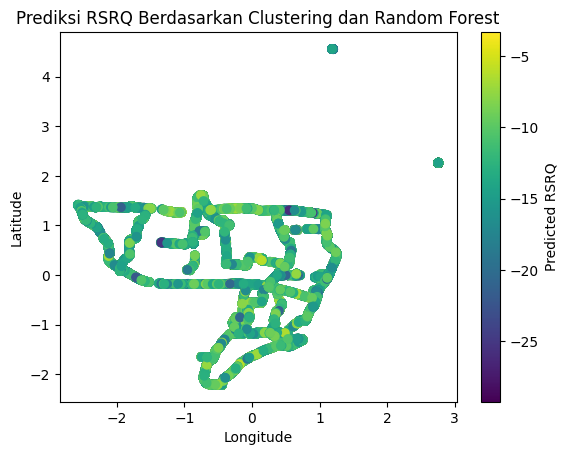

In [16]:
# 5. Visualisasi Hasil
plt.scatter(test_data['Longitude'], test_data['Latitude'], c=test_predictions, cmap='viridis')
plt.colorbar(label='Predicted RSRQ')
plt.title('Prediksi RSRQ Berdasarkan Clustering dan Random Forest')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


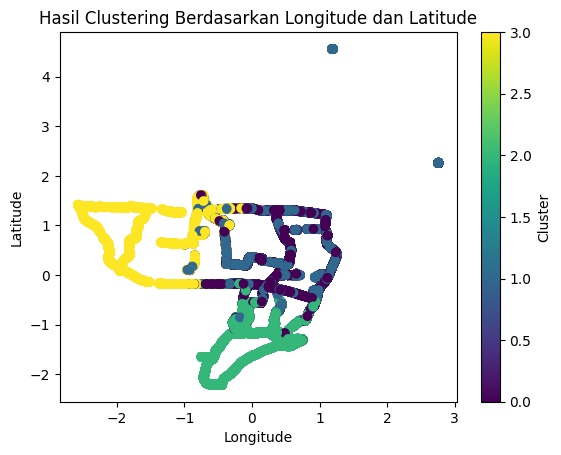

In [17]:
# Visualisasi Hasil Clustering
plt.scatter(test_data['Longitude'], test_data['Latitude'], c=test_data['cluster'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('Hasil Clustering Berdasarkan Longitude dan Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [18]:
# Fungsi untuk memprediksi RSRQ berdasarkan lokasi yang diberikan
def predict_rsrq(rsrp, longitude, latitude):
    # Buat array numpy untuk lokasi yang diberikan
    location = np.array([[rsrp, longitude, latitude]])
    
    # Normalisasi data
    location_scaled = scaler.transform(location)
    
    # Prediksi cluster menggunakan KMeans
    cluster = kmeans.predict(location_scaled)
    
    # Tambahkan informasi cluster ke data lokasi
    location_with_cluster = np.hstack((location_scaled, cluster.reshape(-1, 1)))
    
    # Prediksi RSRQ menggunakan Random Forest
    predicted_rsrq = rf.predict(location_with_cluster)
    
    return predicted_rsrq[0]


In [19]:
# Mengambil rentang nilai longitude dan latitude dari dataset Gabung_Cleaned_2.csv
min_longitude, max_longitude = -106.88175300, -106.75729700
min_latitude, max_latitude = -6.36361500, -6.12620300

# Menghasilkan data acak
np.random.seed(42)  # Untuk konsistensi hasil acak
num_samples = 15

# Longitude dan Latitude acak dalam rentang dari dataset Gabung_Cleaned_2.csv
longitudes = np.random.uniform(min_longitude, max_longitude, num_samples)
latitudes = np.random.uniform(min_latitude, max_latitude, num_samples)

# RSRP acak dalam rentang tertentu
rsrps = np.random.uniform(-120, -40, num_samples)

# Menampilkan data acak
for lon, lat, rsrp in zip(longitudes, latitudes, rsrps):
    rsrq_value = predict_rsrq(rsrp, lon, lat)
    print(f"Longitude: {lon}, Latitude: {lat}, RSRP: {rsrp}, Prediksi RSRQ: {rsrq_value}")

Longitude: -106.83513923496874, Latitude: -6.320072568506677, RSRP: -71.39641184788493, Prediksi RSRQ: -11.609000000000002
Longitude: -106.76343090028145, Latitude: -6.291384240614491, RSRP: -106.35807010501668, Prediksi RSRQ: -16.366999999999997
Longitude: -106.79065196197791, Latitude: -6.239031526053328, RSRP: -114.79587256117765, Prediksi RSRQ: -21.293000000000006
Longitude: -106.80724635969077, Latitude: -6.261066069234138, RSRP: -44.089157019733335, Prediksi RSRQ: -8.504999999999997
Longitude: -106.8623355440851, Latitude: -6.2944737073673025, RSRP: -42.74943735403525, Prediksi RSRQ: -8.504999999999997
Longitude: -106.86233854597704, Latitude: -6.218353780558171, RSRP: -55.328212150683115, Prediksi RSRQ: -8.504999999999997
Longitude: -106.874524145964, Latitude: -6.330497483554877, RSRP: -95.63089846613035, Prediksi RSRQ: -16.77199999999998
Longitude: -106.77395218160143, Latitude: -6.294256354701957, RSRP: -112.18623087948929, Prediksi RSRQ: -20.895000000000003
Longitude: -106.8

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with featu

In [27]:
import pandas as pd
import numpy as np
import pickle

# Load model dan scaler
#with open('kmeans_model.pkl', 'rb') as file:
 #   kmeans = pickle.load(file)

#with open('random_forest_model.pkl', 'rb') as file:
#    rf = pickle.load(file)

#with open('scaler.pkl', 'rb') as file:
 #   scaler = pickle.load(file)

# Fungsi untuk memprediksi RSRQ berdasarkan lokasi yang diberikan
def predict_rsrq(rsrp, longitude, latitude):
    # Buat array numpy untuk lokasi yang diberikan
    location = np.array([[rsrp, longitude, latitude]])
    
    # Normalisasi data
    location_scaled = scaler.transform(location)
    
    # Prediksi cluster menggunakan KMeans
    cluster = kmeans.predict(location_scaled)
    
    # Tambahkan informasi cluster ke data lokasi
    location_with_cluster = np.hstack((location_scaled, cluster.reshape(-1, 1)))
    
    # Prediksi RSRQ menggunakan Random Forest
    predicted_rsrq = rf.predict(location_with_cluster)
    
    return predicted_rsrq[0]

# Baca data dari file Excel
data_dummy = pd.read_excel('data_dummy_2.xlsx')

# Asumsikan data_dummy memiliki kolom 'RSRP', 'Longitude', dan 'Latitude'
predictions = []
for index, row in data_dummy.iterrows():
    rsrq_value = predict_rsrq(row['RSRP'], row['Longitude'], row['Latitude'])
    predictions.append(rsrq_value)

# Tambahkan kolom prediksi RSRQ ke data
data_dummy['Predicted_RSRQ'] = predictions

# Simpan hasil prediksi ke file baru
data_dummy.to_excel('data_dummy_with_predictions.xlsx', index=False)

print("Prediksi RSRQ telah disimpan ke 'data_dummy_with_predictions.xlsx'")#

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with featu

Prediksi RSRQ telah disimpan ke 'data_dummy_with_predictions.xlsx'


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fi

In [20]:
from sklearn.metrics import precision_score, accuracy_score, f1_score

# Asumsikan data_dummy memiliki kolom 'Actual_RSRQ' yang berisi nilai RSRQ sebenarnya
actual_rsrq = data_dummy['Actual_RSRQ']
predicted_rsrq = data_dummy['Predicted_RSRQ']

# Hitung precision, akurasi, dan f1 score
precision = precision_score(actual_rsrq, predicted_rsrq, average='weighted')
accuracy = accuracy_score(actual_rsrq, predicted_rsrq)
f1 = f1_score(actual_rsrq, predicted_rsrq, average='weighted')

print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


NameError: name 'data_dummy' is not defined